# Streamlit app dev and test

Work through code for the streamlist app

In [1]:
__author__      = 'Roy Gardner'

%run ./network_functions.py


## Load the agreement-actor data

- Load data into a binary-valued relation matrix (BVRM) with agreements in rows and actors in columns
- Matrix values are zero except where a relation between an agreement and an actor exists where the value is one
- Apart from the matrix other data are extracted or computed
- All data are stored in data_dict


In [2]:

data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)


In [34]:
print(data_dict['color_map'])

{'AGT': '#e6194b', 'ARM': '#3cb44b', 'COA': '#ffe119', 'CON': '#4363d8', 'ENT': '#f58231', 'IGO': '#911eb4', 'MIL': '#46f0f0', 'NGO': '#f032e6', 'OTH': '#bcf60c', 'POL': '#fabebe', 'UMB': '#008080'}


## Get a peace process sub-matrix

- Create the binary-valued relation matrix containing only the agreements and actors of a defined peace process.
- Data are stored in pp_data_dict


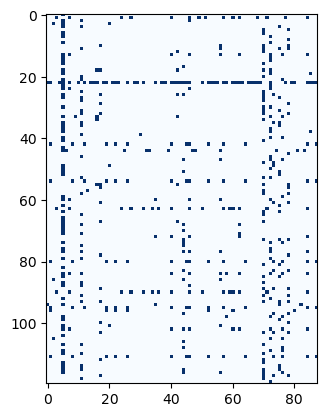

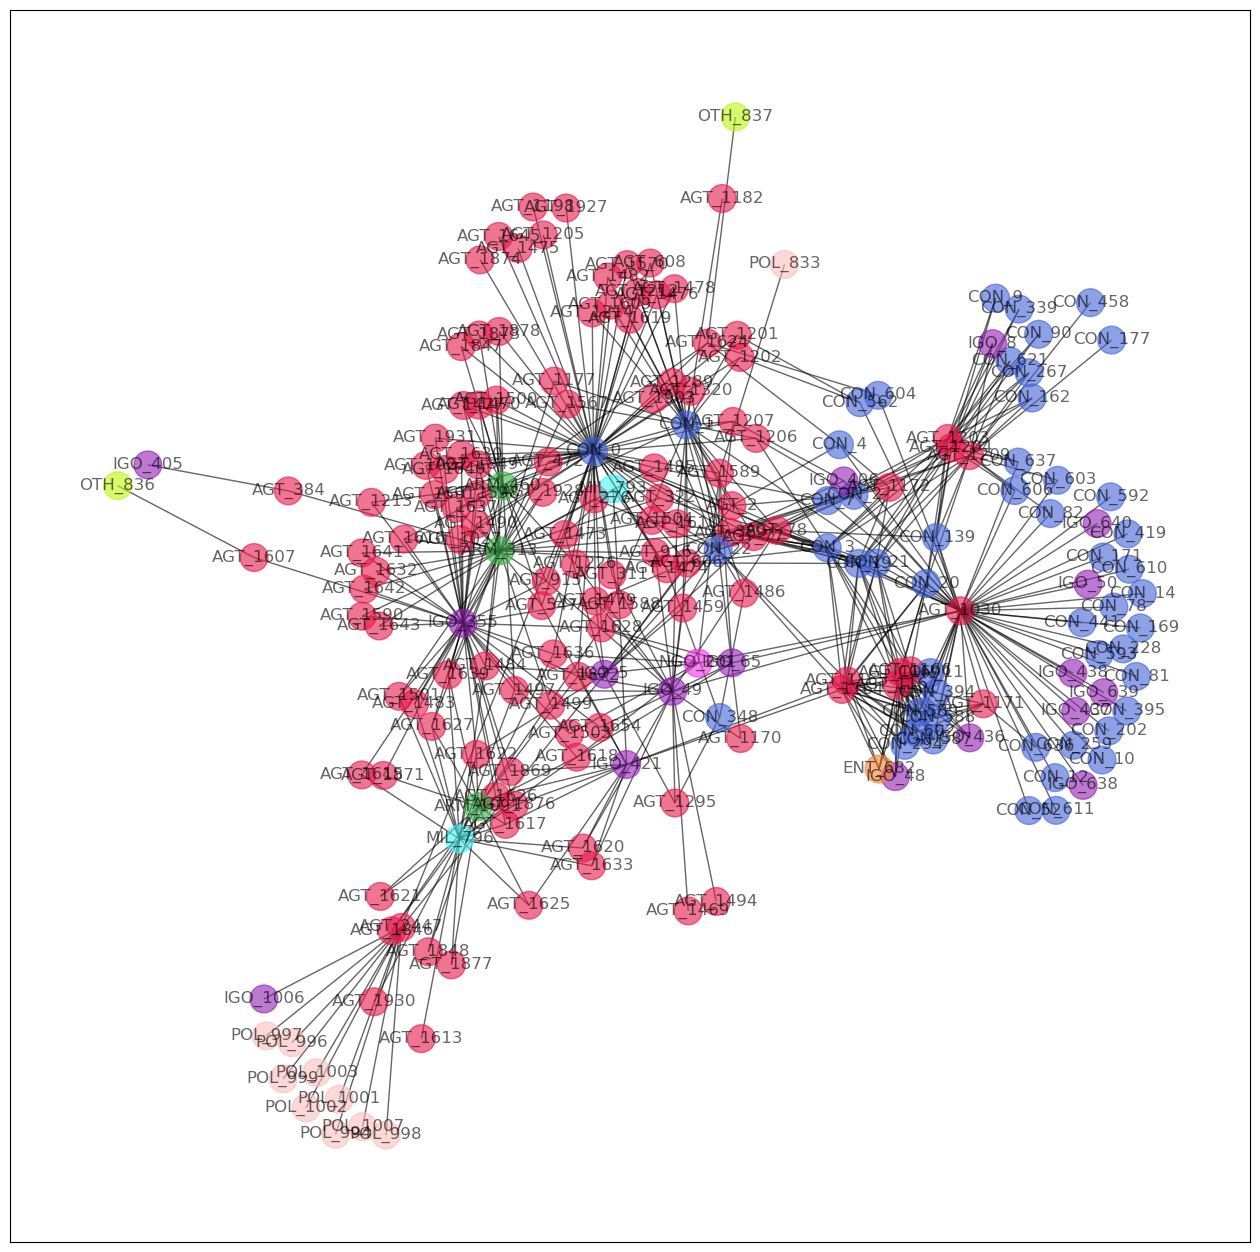

In [4]:

process_name = 'Bosnia peace process'
#process_name = 'Yemen peace process'
#process_name = 'Chad: Doha process'
#process_name = 'DRC: Eastern DRC processes'
#process_name = 'Afghanistan: 2000s Post-intervention process'
#process_name = 'Yemen Inter-group Agreements'

pp_data_dict = get_peace_process_data(process_name,data_dict)
pp_matrix = pp_data_dict['pp_matrix']

plt.imshow(pp_matrix,cmap=plt.cm.Blues)
plt.show()

# Display graph
adj_matrix,adj_vertices = adjacency_from_biadjacency(pp_data_dict)
#print(adj_vertices)
display_networkx_graph(adj_matrix,range(0,len(adj_vertices)),adj_vertices,data_dict)


## Extract values from data dictionaries

In [4]:
print(data_dict['vertices_dict']['CON_264'])
print(pp_data_dict['pp_actor_ids'])

['Actor', '264', 'CON', 'CON_264', 'Country/State', 'Congo, Democratic Republic of the', 'DRC', 'Congo, Democratic Republic of the', 'COD', '89.0', 'Government of DR Congo (Zaire)', 'Government of the Democratic Republic of Congo (2019-)', 'Government of the Democratic Republic of Congo (1997-2001) | Government of the Democratic Republic of Congo (2001-2019) | Government of the Democratic Republic of Congo (2019-)', 'Congo, Democratic Republic of (Zaire) | CONGO, THE DEMOCRATIC REPUBLIC OF | Democratic Republic | Democratic Republic Congo | Republic Democratic Republic Congo', 'Congo, Democratic Republic of the is a Country/State in Africa. ', '', '', '', '', '', '', '', '', '', '']
['CON_176', 'IGO_624', 'IGO_493', 'IGO_338', 'NGO_973', 'MIL_978', 'OTH_1020', 'CON_3', 'IGO_49', 'CON_392', 'ARM_976', 'UMB_979', 'NGO_1022', 'OTH_981', 'CON_253', 'NGO_1019', 'NGO_977', 'ARM_623', 'ARM_407', 'NGO_197', 'OTH_982', 'IGO_87', 'IGO_5', 'ARM_1023', 'OTH_1021', 'ARM_971', 'ARM_622', 'ARM_980', 

In [5]:
# Get actors in alpha order
actor_options = [(vertex_id,data_dict['vertices_dict'][vertex_id][5]) for vertex_id in\
                 pp_data_dict['pp_actor_ids']]
actor_options = sorted(actor_options,key=lambda t:t[1])
actor_options = [t[0] + ': ' + t[1] for t in actor_options]

# Get agreements in date order
agreement_options = [(vertex_id,data_dict['vertices_dict'][vertex_id][5],data_dict['dates_dict'][vertex_id])\
                     for vertex_id in pp_data_dict['pp_agreement_ids']]
agreement_options = sorted(agreement_options,key=lambda t:t[2])
agreement_options = [t[0] + ': ' + t[1] for t in agreement_options]


In [ ]:
print()

## Query peace process networks

### Query based on DFS in adjacency matrix

Notes:
- That depth 2 (and above) will yield the entire graph because the graph is bipartite.
- Should be either/or with respect to entity type.


CON_20 China
CON_21 Russia



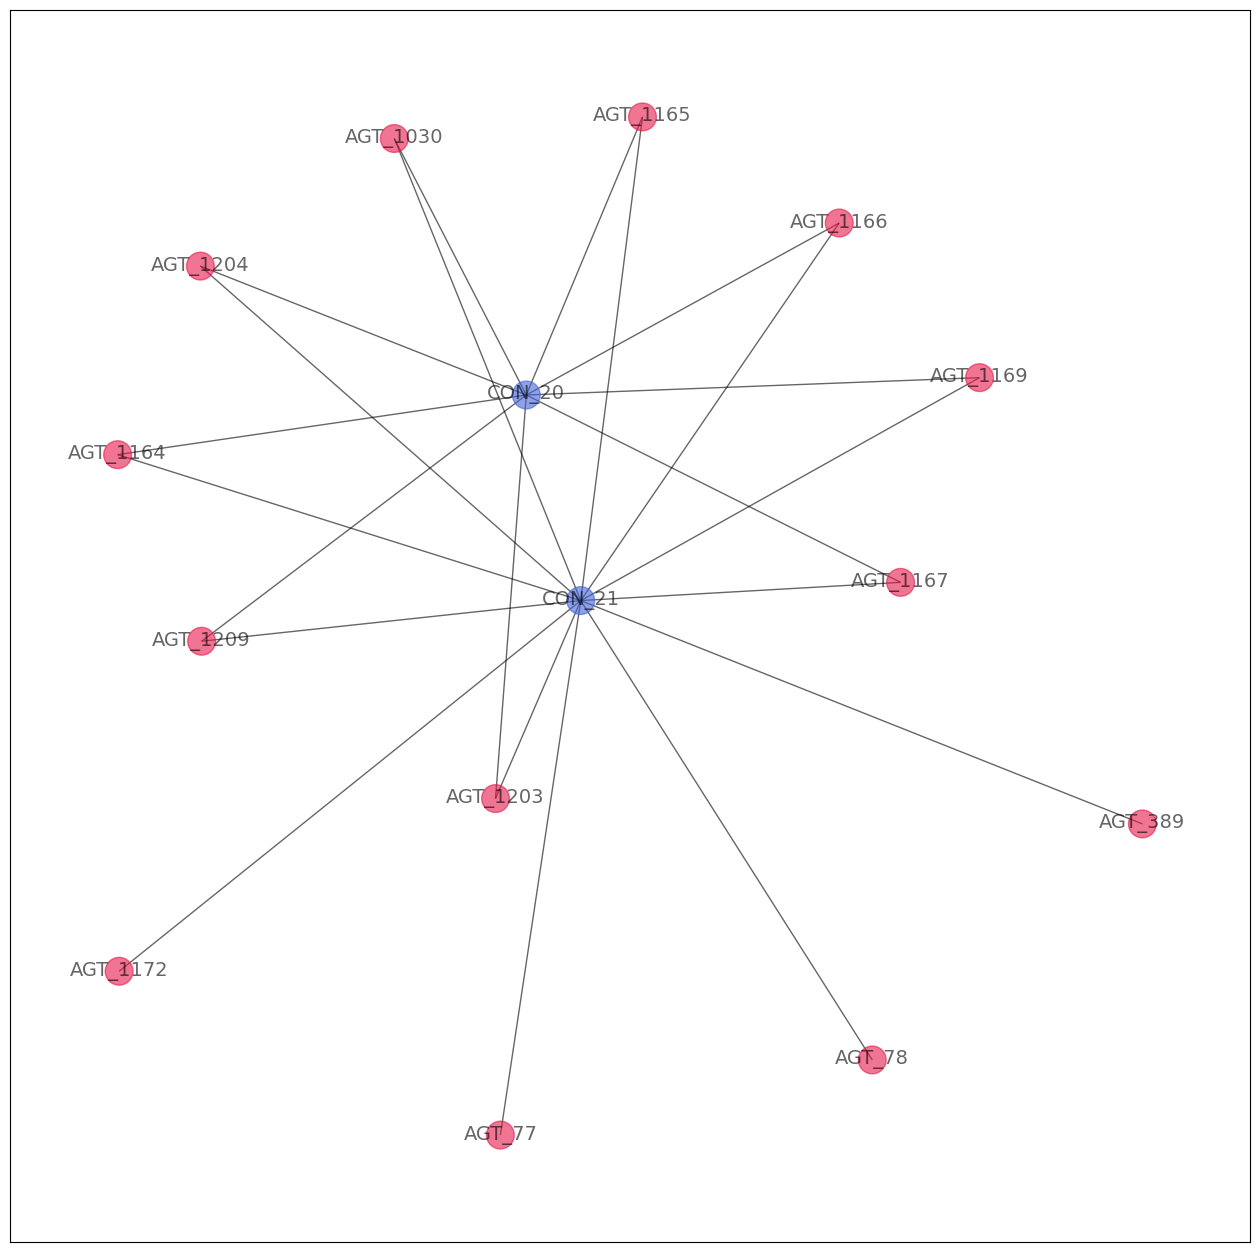

In [32]:

# Convert a peace process biadjacency matrix to an adjacency matrix
adj_matrix,adj_vertices = adjacency_from_biadjacency(pp_data_dict)

query_vertices = ['CON_19','CON_20','CON_21']
query_vertices = ['CON_20','CON_21']
#query_vertices = ['CON_4','ARM_460']
#query_vertices = ['IGO_5','CON_20','CON_4']
#query_vertices = ['AGT_2447']
for vertex in query_vertices:
    print(vertex,data_dict['vertices_dict'][vertex][5])
print()

query_indices = [adj_vertices.index(vertex) for vertex in query_vertices]
query_matrix,found_indices = get_query_matrix(query_indices,adj_matrix,operator='OR')
display_networkx_graph(query_matrix,found_indices,adj_vertices,data_dict)


## Actor engagements over time in peace process

(88, 120)


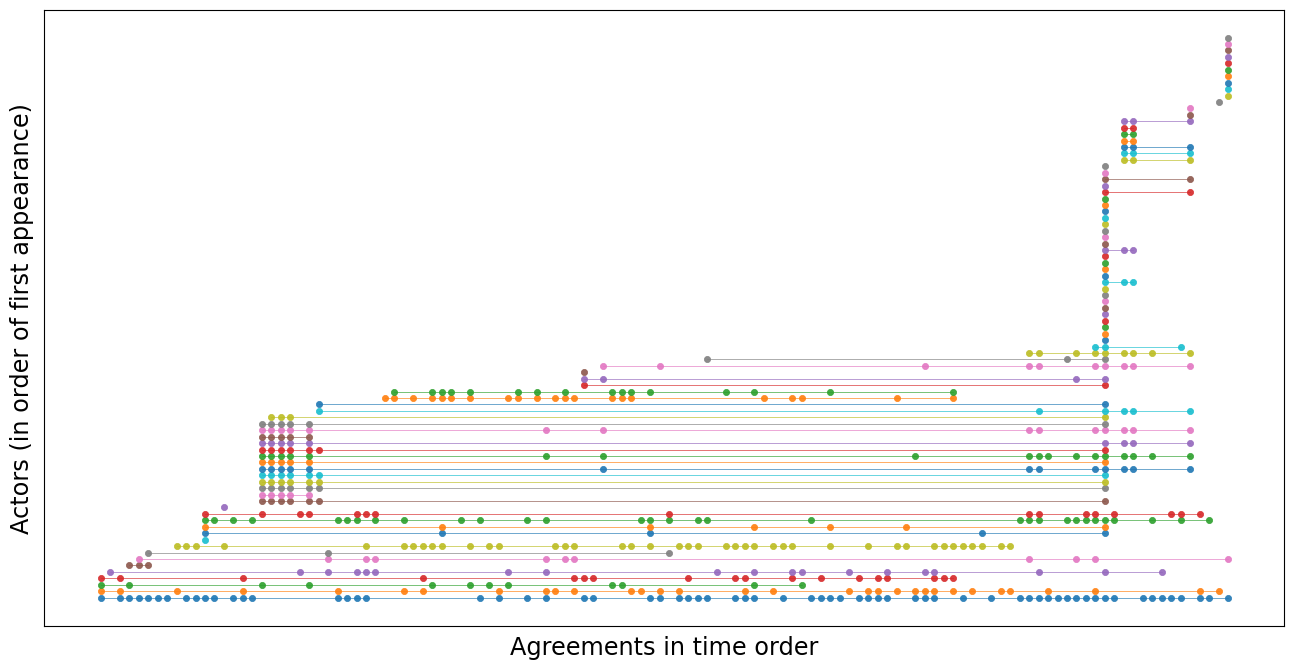

In [7]:
#print(data_dict['dates_dict'])

#print(pp_data_dict['pp_agreement_ids'])
pp_ag_ids = pp_data_dict['pp_agreement_ids']

t_list = []
for i,agreement_id in enumerate(pp_ag_ids):
    if not agreement_id in data_dict['dates_dict']:
        continue
    ag_date = data_dict['dates_dict'][agreement_id]
    t_list.append((i,ag_date))
# Sort by date    
t_list = sorted(t_list,key=lambda t:t[1])
    
# Build a time-order agreement-actor matrix
ordered_matrix = []
for t in t_list:
    ordered_matrix.append(pp_data_dict['pp_matrix'][t[0]])
    
ordered_matrix = np.array(ordered_matrix)
# Put actors in rows
ordered_matrix = ordered_matrix.T

print(ordered_matrix.shape)

# Now order actors by first appearance in process
row_indices = []
for i,row in enumerate(ordered_matrix):
    where = np.where(row==1)
    v = 0
    if len(where[0]) > 0:
        v = where[0][0]
    row_indices.append((i,v))
sorted_row_indices = [t[0] for t in sorted(row_indices,key=lambda t:t[1])]

sorted_matrix = ordered_matrix[np.ix_(sorted_row_indices)]

f = plt.figure(figsize=(16,8))
for i,row in enumerate(sorted_matrix):
    x = [j for j,x in enumerate(row) if x > 0]
    y = [i]*len(x)
    plt.scatter(x,y,alpha=0.9,linewidth=0.5,s=20)
    plt.plot(x,y,alpha=0.9,linewidth=0.5)
xint = range(0, sorted_matrix.shape[1])
plt.xticks([],fontsize='xx-large')    
yint = range(0, sorted_matrix.shape[1])
plt.yticks([],fontsize='xx-large')    
plt.ylabel('Actors (in order of first appearance)',fontsize='xx-large')
plt.xlabel('Agreements in time order',fontsize='xx-large')
plt.show()



## Build an actor-year matrix

[1999, 2001, 2002, 2004, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2014, 2016, 2019, 2020]


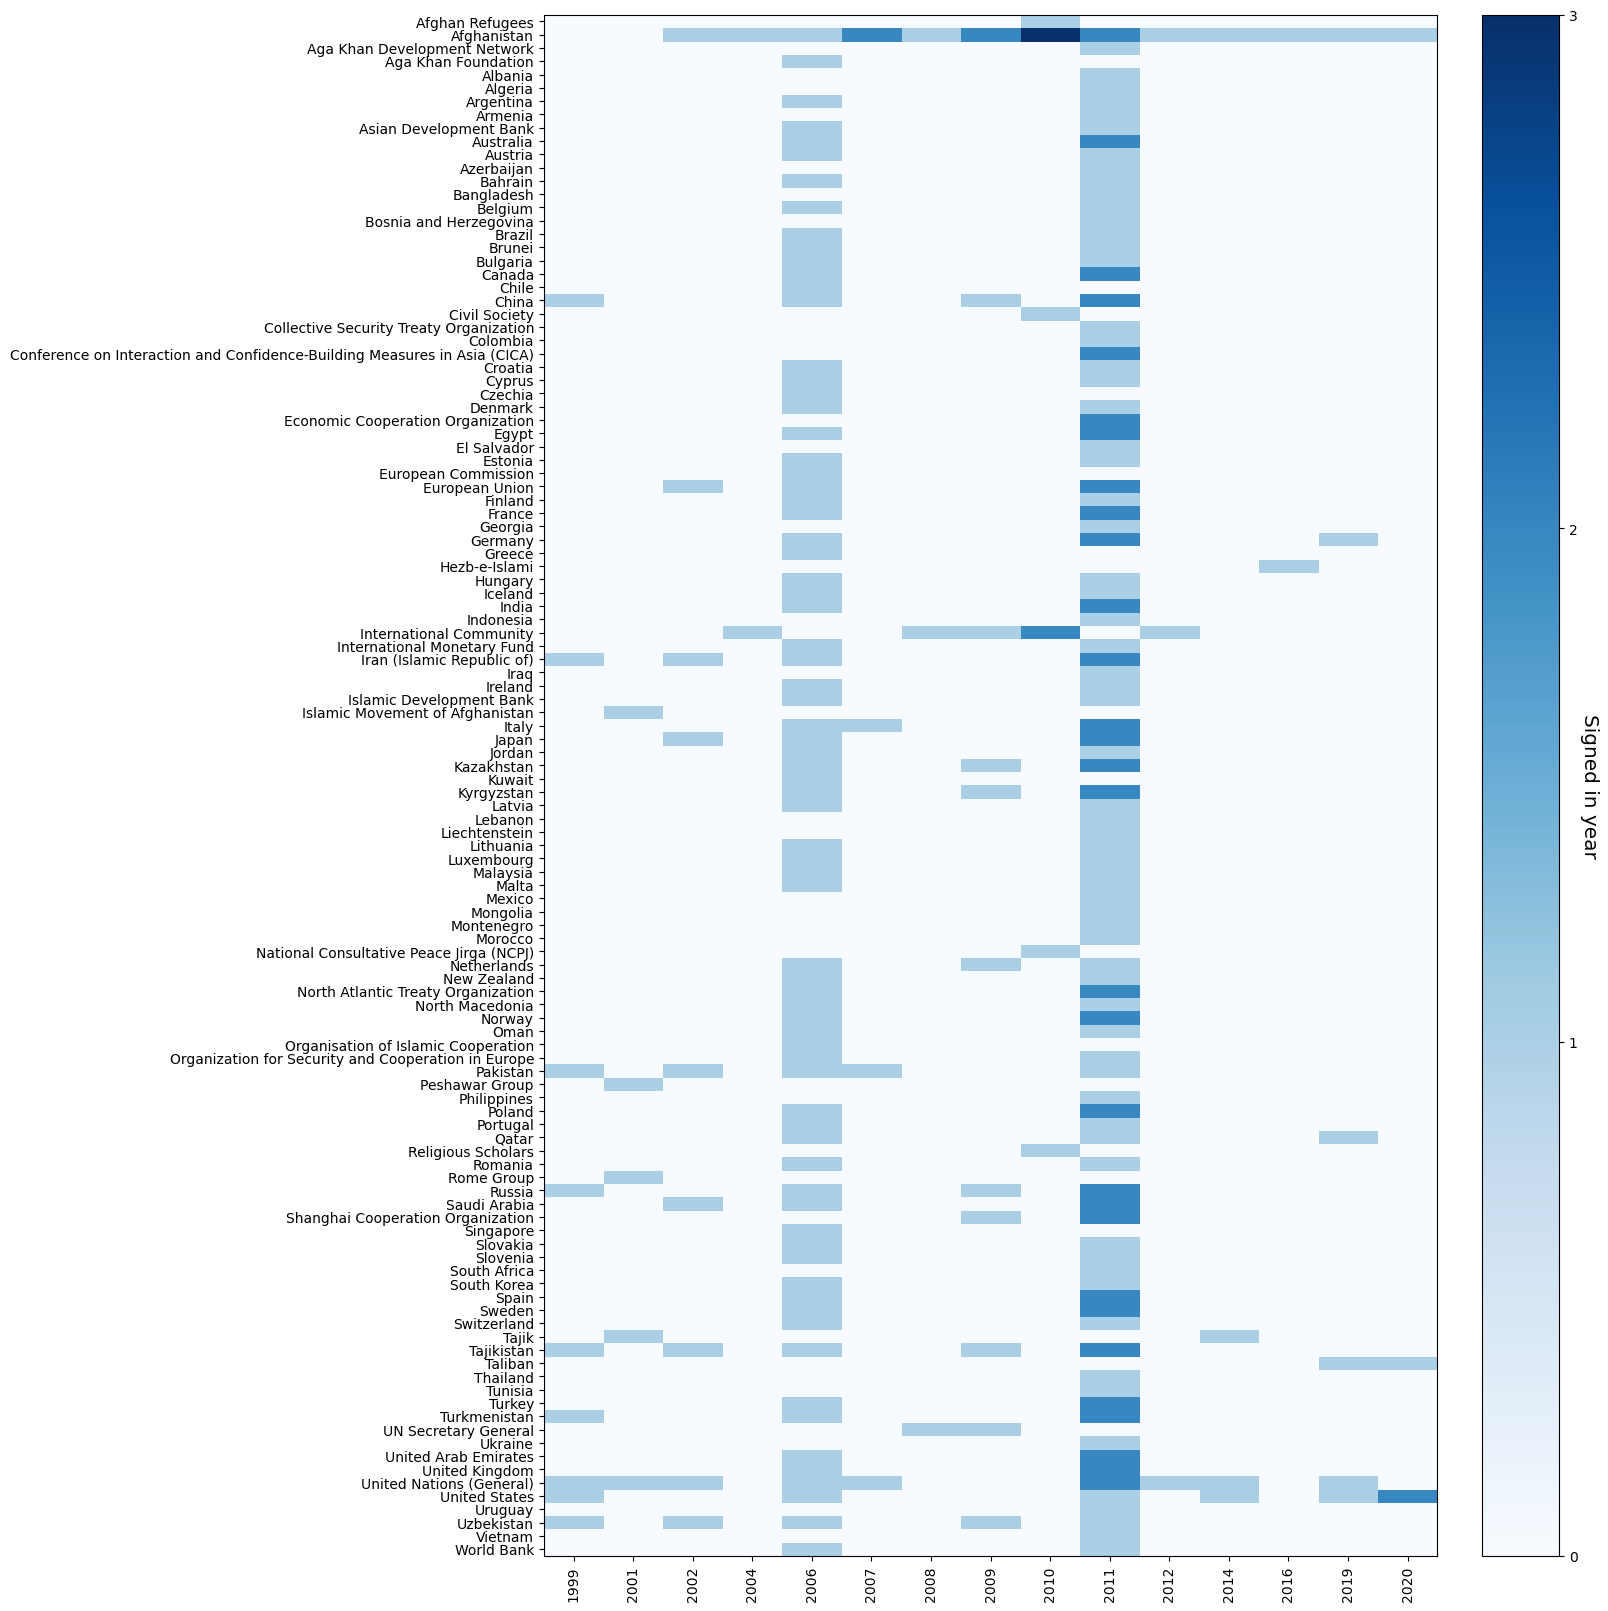

In [15]:
labels = [data_dict['vertices_dict'][v][5] for v in pp_data_dict['pp_actor_ids']]
z = list(zip(range(0,len(labels)),labels))
z = sorted(z,key=lambda t:t[1])

# Get a sorted list of years

pp_ag_ids = pp_data_dict['pp_agreement_ids']

year_list = []
for i,agreement_id in enumerate(pp_ag_ids):
    if not agreement_id in data_dict['dates_dict']:
        continue
    ag_year = int(str(data_dict['dates_dict'][agreement_id])[0:4])
    year_list.append(ag_year)
# Sort by year    
year_list = sorted(set(year_list))
print(year_list)

year_matrix = np.zeros((len(pp_data_dict['pp_actor_ids']),len(year_list)))

matrix_t = pp_data_dict['pp_matrix'].T
for i,row in enumerate(matrix_t):
    for j,v in enumerate(row):
        if v == 0:
            continue
        agreement_id = pp_data_dict['pp_agreement_ids'][j]
        year = int(str(data_dict['dates_dict'][agreement_id])[0:4])
        year_index = year_list.index(year)
        year_matrix[i][year_index] += 1
        
# Get matrix in actor alpha order
ordered_year_matrix = []
for t in z:
    ordered_year_matrix.append(year_matrix[t[0]])
    
ordered_year_matrix = np.array(ordered_year_matrix)
        
        
fig = plt.figure(figsize=(16,16),layout="constrained")
plt.imshow(ordered_year_matrix,aspect='auto',cmap=plt.cm.Blues)
plt.xticks(range(0,len(year_list)),year_list,rotation=90)
plt.yticks(range(0,len(labels)),[t[1] for t in z])
cbar = plt.colorbar()
yint = range(0, math.ceil(np.amax(ordered_year_matrix))+1)
cbar.set_ticks(yint)
cbar.set_label('Signed in year',rotation=270,labelpad=15,fontsize='x-large')
plt.show()


## Compute co-occurence matrices

Paths of length 2 between actors

Use a peace process binary-valued relation matrix to compute co-occurences:
- For a pair of actors, the number of agreements in common
- For a pair of agreements, the number of actors in common


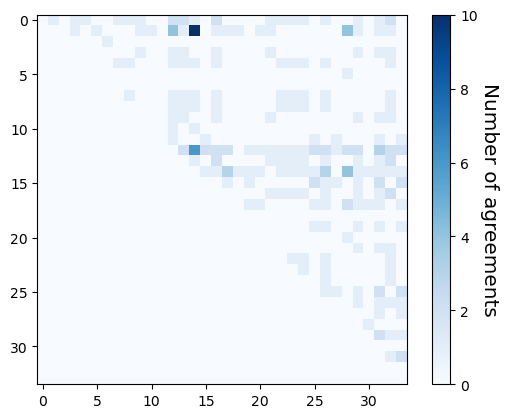

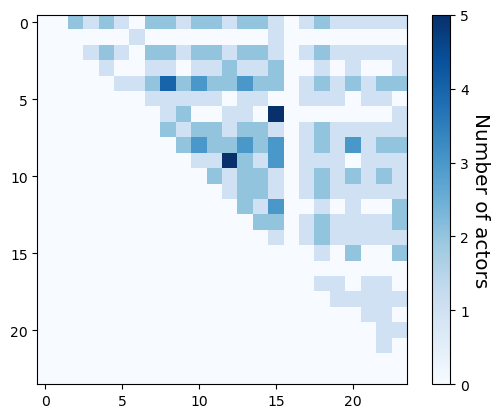

Actors who are co-signatories to the greatest number of agreements: Yemen (CON_304) and Ansar Allah (ARM_568)
Number of agreements: 10

Agreements with the greatest number of co-signatories: Agreement on the Implementation Mechanism for the Transition Process in Yemen in Accordance with the Initiative of the Gulf Cooperation Council (GCC Implementation Mechanism) (AGT_758) and National Dialogue Conference Outcomes Document (AGT_1400)
Number of co-signatories: 5



In [4]:
co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
actor_upper = np.triu(co_matrices[0],k=1)
agreement_upper = np.triu(co_matrices[1],k=1)

plt.imshow(actor_upper,cmap=plt.cm.Blues)
cbar = plt.colorbar()
cbar.set_label('Number of agreements',rotation=270,labelpad=15,fontsize='x-large')
plt.show()

plt.imshow(agreement_upper,cmap=plt.cm.Blues)
cbar = plt.colorbar()
cbar.set_label('Number of actors',rotation=270,labelpad=15,fontsize='x-large')
plt.show()

# Actors with max agreements between them
indices = np.unravel_index(np.argmax(actor_upper,axis=None),actor_upper.shape)
actors = [(pp_data_dict['pp_actor_ids'][index],\
           data_dict['vertices_dict'][pp_data_dict['pp_actor_ids'][index]][5]) for index in indices]
s = actors[0][1] + ' (' + actors[0][0] + ') and ' + actors[1][1] + ' (' + actors[1][0] + ')'
print('Actors who are co-signatories to the greatest number of agreements:',s)
print('Number of agreements:',actor_upper[indices])
print()

# Agreements with max actors between them
indices = np.unravel_index(np.argmax(agreement_upper,axis=None),agreement_upper.shape)
agreements = [(pp_data_dict['pp_agreement_ids'][index],\
               data_dict['vertices_dict'][pp_data_dict['pp_agreement_ids'][index]][5]) for index in indices]
s = agreements[0][1] + ' (' + agreements[0][0] + ') and ' + agreements[1][1] + ' (' + agreements[1][0] + ')'
print('Agreements with the greatest number of co-signatories:',s)
print('Number of co-signatories:',agreement_upper[indices])
print()



In [ ]:
print(data_dict['nodes_header'])

## Retrieving co-occurrence entities


### Actors

In [ ]:

actor = 'CON_4'
print('Agreements signed by',actor,get_actor_name(actor,data_dict))
agreements = get_agreements(actor,pp_data_dict)
tuples = [(agreement,get_agreement_name(agreement,data_dict)) for agreement in agreements]
tuples = sorted(tuples,key=lambda t:t[1])
for t in tuples:
    print(t[0],t[1])
print()

print('Cosignatories of',actor,get_actor_name(actor,data_dict))
cosigns = get_consignatories(actor,pp_data_dict)
tuples = [(cosign,get_actor_name(cosign,data_dict)) for cosign in cosigns]
tuples = sorted(tuples,key=lambda t:t[1])
for t in tuples:
    print(t[0],t[1])
print()

print('Cosignatories of',actor,'organised by agreement')
agreement_cosign_dict = {}
for cosign in cosigns:
    agreements = get_consignatory_agreements([actor,cosign],pp_data_dict)
    for agreement in agreements:
        if agreement in agreement_cosign_dict:
            agreement_cosign_dict[agreement].append((cosign,get_actor_name(cosign,data_dict)))
        else:
            agreement_cosign_dict[agreement] = [(cosign,get_actor_name(cosign,data_dict))]
for agreement,actors in agreement_cosign_dict.items():
    print(agreement,get_agreement_name(agreement,data_dict))
    print(actors)
    print()
print()



### Agreements

In [18]:
print(data_dict['nodes_header'])

['overall_node_type', 'id', 'type', 'node_id', 'node_type', 'node_name', 'abbreviation', 'country_based', 'node_country', 'ucdp_id', 'in_ucdp', 'acled_name', 'acled_other', 'alternative_names', 'description', 'date', 'year', 'month', 'day', 'month_full', 'PP', 'PPName', 'Loc2ISO', 'PA-X Hyperlink', 'PDF Hyperlink']


In [23]:
agreement = 'AGT_1030'
print('Signatories',agreement,get_agreement_name(agreement,data_dict))
actors = get_actors(agreement,pp_data_dict)
tuples = [(actor,get_actor_name(actor,data_dict)) for actor in actors]
tuples = sorted(tuples,key=lambda t:t[1])
for t in tuples:
    print(t[0],t[1])
print()

print('Agreements with signatories in common with',agreement)
coagrees = get_coagreements(agreement,pp_data_dict)
print(coagrees)    
print()

print('Agreements with co-signatories of',agreement,'organised by cosignatory')
cosign_agreement_dict = {}
for coagree in coagrees:
    cosignatories = get_agreement_cosignatories([agreement,coagree],pp_data_dict)
    for cosign in cosignatories:
        if cosign in cosign_agreement_dict:
            cosign_agreement_dict[cosign].append(coagree)
        else:
            cosign_agreement_dict[cosign] = [coagree]
            
#print(cosign_agreement_dict)

print()

agreement_ids = []
for _,v in cosign_agreement_dict.items():
    agreement_ids.extend(v)
agreement_ids = list(set(agreement_ids))
agreements = []
for agreement_id in agreement_ids:
    agreements.append((agreement_id,get_agreement_name(agreement_id,data_dict),get_agreement_date(agreement_id,data_dict)))

agreements = sorted(agreements,key=lambda t:t[2])
for t in agreements:
    s = t[0] + ' ' + t[1] + ' [' + t[2] + ']'
    print(str(s))



Signatories AGT_1030 Conclusions of the Peace Implementation Conference held at Lancaster House (London Conference)
CON_587 Albania
CON_588 Austria
CON_441 Belgium
CON_0 Bosnia and Herzegovina
CON_589 Bulgaria
CON_11 Canada
CON_20 China
IGO_639 Council of Europe
CON_1 Croatia
CON_637 Czechia
CON_604 Denmark
CON_82 Egypt
IGO_638 European Bank for Reconstruction and Development
IGO_436 European Commission
CON_171 Finland
CON_7 France
CON_2 Germany
CON_636 Greece
IGO_65 High Commission for Refugees
CON_602 Hungary
NGO_201 International Committee of the Red Cross
IGO_438 International Monetary Fund
CON_169 Ireland
CON_139 Italy
CON_294 Japan
CON_78 Jordan
CON_611 Luxembourg
CON_12 Malaysia
CON_228 Morocco
CON_10 Netherlands
IGO_406 North Atlantic Treaty Organization
CON_610 North Macedonia
CON_81 Norway
IGO_640 Office of the United Nations High Commissioner for Human Rights
CON_606 Oman
IGO_50 Organization for Security and Cooperation in Europe
CON_395 Pakistan
CON_603 Poland
CON_259 Portu

In [ ]:

co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
#print(list(co_matrices[0]))

# Find agreements that a pair of actors have in common
# Define indices for a pair of actors

actors = ['CON_20','CON_21']
actor_indices = [pp_data_dict['pp_actor_ids'].index(actor_id) for actor_id in actors]

# Number in co-occurrence cell
print(co_matrices[0][actor_indices[0]][actor_indices[1]])

# Get the row from the transpose of pp matrix
row1 = pp_data_dict['pp_matrix'].T[actor_indices[0]]
# Get the row from the pp matrix
row2 = pp_data_dict['pp_matrix'].T[actor_indices[1]]


x = np.bitwise_and(row1,row2)


#print(len(x)) # The number of agreements

for index,value in enumerate(x): 
    if value == 1:
        print(pp_data_dict['pp_agreement_ids'][index],\
              data_dict['vertices_dict'][pp_data_dict['pp_agreement_ids'][index]][5])


## Paths of length 4 

Bipartite equivalent of friend-of-a-friend. A path 4 between two actors who are not cosignatories, means there's another actor who is a cosignatory to the agreements of both actors. Therefore the mediating actor is a cosignatory with both path 4 actors, i.e., the intersection of the actor cosignatory sets.


In [ ]:
co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])

actor_2_paths = co_matrices[0]
actor_4_paths = np.linalg.matrix_power(actor_2_paths,2)

actor_2_paths[actor_2_paths != 0] = 1
actor_4_paths[actor_4_paths != 0] = 1

co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
# Remove all actors with a path 2 
U = np.linalg.matrix_power(co_matrices[0],2) * np.bitwise_xor(actor_2_paths,actor_4_paths)

upper = np.triu(U,k=1)
plt.imshow(upper,cmap=plt.cm.Blues)
cbar = plt.colorbar()
cbar.set_label('Number of actors',rotation=270,labelpad=15,fontsize='x-large')
plt.show()

print(np.argmax(upper,axis=None))
actor_indices = np.unravel_index(np.argmax(upper,axis=None),upper.shape)
actors = [(pp_data_dict['pp_actor_ids'][index],\
           data_dict['vertices_dict'][pp_data_dict['pp_actor_ids'][index]][5]) for index in actor_indices]
print(actors)

cosigns1 = get_consignatories('CON_1',pp_data_dict)
print(sorted(cosigns1))
print()

cosigns2 = get_consignatories('ARM_460',pp_data_dict)
print(sorted(cosigns2))
print()

print(sorted(list(set(cosigns1).intersection(cosigns2))))


## Actor diagonal by stage

In [ ]:
stage_dict = {}
stage_dict['Cea'] = [1,'Ceasefire related']
stage_dict['Pre'] = [2,'Pre-negotiation process']
stage_dict['SubPar'] = [3,'Partial Framework - substantive']
stage_dict['SubComp'] = [4,'Comprehensive Framework - substantive']
stage_dict['Ren'] = [5,'Implementation Renegotiation/Renewal']
stage_dict['Imp'] = [5,'Implementation Renegotiation/Renewal']
stage_dict['Oth'] = [0,'']

# Map agreements on to stages
stage_map = {}
for i,agreement_id in enumerate(pp_data_dict['pp_agreement_ids']):
    ss_id = agreement_id.split('_')[1]
    if ss_id in data_dict['agreements_dict']:
        stage_map[i] = stage_dict[data_dict['agreements_dict'][ss_id]['Stage']][0]
    else:
        stage_map[i] = 0
    
print(len(stage_map))
print(len(pp_data_dict['pp_agreement_ids']))

print(len([v for _,v in stage_map.items() if v == 0]))


In [ ]:

co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
actor_diag = np.diag(co_matrices[0])

# Plot

labels = [data_dict['vertices_dict'][v][5] for v in pp_data_dict['pp_actor_ids']]
z = list(zip(labels,actor_diag))
z = sorted(z,key=lambda t:t[1])
values = [t[1] for t in z]
        
        
fig = plt.figure(figsize=(16,16),layout="constrained")

gs = GridSpec(1, 6, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax1.barh(range(0,len(actor_diag)),values)
ax1.set_yticks(range(0,len(actor_diag)),[t[0] for t in z],fontsize='large')
ax1.set_xlim(0,max(values)+5)
ax1.margins(y=0)
ax1.set_title('All Stages',fontsize='xx-large')

print(z)
print()

stage_levels = [1,2,3,4,5]
for i,stage_level in enumerate(stage_levels):
    stage_agreement_indices = [k for k,v in stage_map.items() if v == stage_level]

    stage_matrix = pp_data_dict['pp_matrix'][np.ix_(stage_agreement_indices)]

    co_matrices = get_cooccurrence_matrices(stage_matrix)
    
    # Same order as all agreements so y-axes are consistent
    actor_diag = np.diag(co_matrices[0])
    x = list(zip(labels,actor_diag))
    x = sorted(x,key=lambda t:[g[0] for g in z].index(t[0]))
    #print(x)
    print()
    
    ax = fig.add_subplot(gs[0,i+1])
    ax.barh(range(0,len(actor_diag)),[t[1] for t in x])

    ax.set_yticks([],[])
    ax.set_xlim(0,max(values)+5)
    ax.margins(y=0)
    ax.set_title('Level ' + str(stage_level),fontsize='xx-large')


fig.suptitle('Actor Signatory Counts by Agreement Stage',fontsize='xx-large')

plt.show()

In [ ]:
co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
actor_diag = np.diag(co_matrices[0])

# Plot

labels = [data_dict['vertices_dict'][v][5] for v in pp_data_dict['pp_actor_ids']]
z = list(zip(labels,actor_diag))
z = sorted(z,key=lambda t:t[1])
print(len(z))

f = plt.figure(figsize=(8,32))
plt.barh(range(0,len(actor_diag)),[t[1] for t in z])
plt.yticks(range(0,len(actor_diag)),[t[0] for t in z],fontsize='large')
plt.xlabel('Number of agreements to which actor is signatory')
plt.show()


## Build process-actor matrix

In [ ]:
# Build a peace process-actor matrix

data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)

# Get list of peace processes
processes = get_peace_processes(data_dict)


process_matrix = np.zeros((len(processes),len(data_dict['actor_vertices'])), dtype=int)

for i,process_name in enumerate(processes):
    process_data = get_peace_process_data(process_name,data_dict)
    actor_marginal = [sum(row) for row in process_data['pp_matrix'].T]
    actor_indices = [data_dict['actor_vertices'].index(actor_id) for actor_id in process_data['pp_actor_ids']]
    for j,v in enumerate(actor_marginal):
        if v > 0:
            process_matrix[i][actor_indices[j]] = 1

plt.imshow(process_matrix,cmap=plt.cm.Blues,aspect='auto')

proc_co = get_cooccurrence_matrices(process_matrix)



In [ ]:


data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)
matrix = data_dict['matrix']


# Matrix plot routines
print(matrix.shape)
f = plt.figure(figsize=(32,32))
plt.imshow(complete_matrix,aspect='auto')
plt.show()

# Get the column marginals
col_marginals = []
for row in complete_matrix.T:
    col_marginals.append(sum(row))


plt.plot(range(0,len(col_marginals)),col_marginals)
plt.show()

max_i = col_marginals.index(max(col_marginals))
max_actor = to_vertices[max_i]
print(max_actor,vertices_dict[max_actor][5])


In [ ]:
x = np.argsort(col_marginals)[::-1][:5]
print("Indices:",x)
